# Optimizing Deep Q Learning with SHAP Explanations
Exploring Minimum Experience Replay Buffer Sizes for Reinforcement Learning

## Import Libraries

In [1]:
#basic
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

#pytorch for gpu processing of ML model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable

#hide pytorch warnings (should eventually be resolved)
import warnings
warnings.filterwarnings("ignore")

#Simulations
from hrl_gym import hrl_gym #simulate addiction
import gymnasium as gym

## Agent's Brain (Deep Q-Learning)

### Neural Network Model

In [2]:
class Network(nn.Module):  
    def __init__(self, input_size, nb_action):
        #ref: https://discuss.pytorch.org/t/super-model-in-init/97426
        #super(Network, self).__init__()
        super().__init__() #pytorch's NN model
        self.input_size = input_size
        self.nb_action = nb_action
        self.fc1 = nn.Linear(input_size, 30)#arbitrarily chose 30 hidden layers
        self.fc2 = nn.Linear(30, nb_action)
    
    #base pytorch NN model runs and we override the
    #forward function with our own relu activation function
    def forward(self, state):
        x = F.relu(self.fc1(state))
        q_values = self.fc2(x)
        return q_values

### Experience Replay Model
This model is used for training our DQN model. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

In [3]:
class ReplayMemory(): 
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
    
    def push(self, event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            del self.memory[0] #forget first transition
    
    def sample(self, batch_size):
        samples = zip(*random.sample(self.memory, batch_size))
        return map(lambda x: Variable(torch.cat(x, 0)), samples)

### DQN Ensemble
Comprised of a neural network model and a memory model. 
* The NN takes in observation of sensor data (brain chemicals) and chooses actions based on the relu activation function. 
* The agent will sample some of the sensor data and store in long term memory to be reused later for training. 
* We also use the Adam Optimisation algorithm. This is an extension to stocastic gradient desent to update weights of the neural network. 

In [4]:
class Dqn():
    def __init__(self, input_size, nb_action, gamma, capacity=100000, learning=0.001, temperature=100):
        self.gamma = gamma
        self.reward_window = []
        self.model = Network(input_size, nb_action)
        self.memory = ReplayMemory(capacity) #100k to 50k to 12.5k to 6.25k
        self.optimizer = optim.Adam(self.model.parameters(), lr = learning)
        self.last_state = torch.Tensor(input_size).unsqueeze(0)
        self.last_action = 0
        self.last_reward = 0
        self.temp = temperature

    # select action for x duration
    def select_action(self, state):
        #softmax converts numbers into probabilities
        #Q values are the output of the neural network
            #view q values
        q_value_tensor = self.model(Variable(state, volatile = True)) 
        q_values = [q_value.detach().numpy() for q_value in q_value_tensor]
            #print(q_values)
            #viz q value for each action, (T value by user choice)
            #pie chart 0/1 #seperate action
        # Temperature value = 100. closer to zero the less sure the NN will be to taking the action
        probs = F.softmax(self.model(Variable(state, volatile = True))*self.temp) # T=100
        
        action_prob = [prob.detach().numpy() for prob in probs]

        action = probs.multinomial(num_samples=1) # action taken
        #q_values[0][action] #quality of taking action in state
        #action_prob[0][action] #probability of taking action

        #return the action taken, q values and probabilities of taking action given state.
        #return action.data[0,0], q_values[0][action], action_prob[0][action]
        return action.data[0,0], q_values, action_prob
    
    #to train our AI
    #forward propagation then backproagation
    # get our output, target, compare our output to the target to compute the loss error
    # backproagate loss error into the nn and use stochastic gradient descent we update the weights according to how much they contributed to the loss error
    def learn(self, batch_state, batch_next_state, batch_reward, batch_action):
        outputs = self.model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
        next_outputs = self.model(batch_next_state).detach().max(1)[0]
        target = self.gamma*next_outputs + batch_reward
        td_loss = F.smooth_l1_loss(outputs, target)
        self.optimizer.zero_grad()
        td_loss.backward(retain_graph = True)
        self.optimizer.step()
    
    #When ai reaches a new state we update everything
    #update action, last action becomes the new action but also the last state becomes the new state and last reward becomes the new state
    # we then get this new transition and update our reward window to track training progress and exploration
    def update(self, reward, new_signal):
        new_state = torch.Tensor(new_signal).float().unsqueeze(0)
        self.memory.push((self.last_state, new_state, torch.LongTensor([int(self.last_action)]), torch.Tensor([self.last_reward])))
        action, q, p = self.select_action(new_state)
        if len(self.memory.memory) > 100:
            batch_state, batch_next_state, batch_action, batch_reward = self.memory.sample(100)
            self.learn(batch_state, batch_next_state, batch_reward, batch_action)
        self.last_action = action
        self.last_state = new_state
        self.last_reward = reward
        self.reward_window.append(reward)
        #if len(self.reward_window) > 1000:
        #    del self.reward_window[0]
        return action, q, p
    
    def score(self):
        #return sum(self.reward_window)/(len(self.reward_window)+1.0)
        return sum(self.reward_window)
    
    def save(self):
        torch.save({'state_dict': self.model.state_dict(),
                    'optimizer' : self.optimizer.state_dict(),
                   }, 'last_brain.pth')
    def load(self):
        if os.path.isfile('last_brain.pth'):
            print("=> loading checkpoint... ")
            checkpoint = torch.load('last_brain.pth')
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            print("done !")
        else:
            print("no checkpoint found...")

## Experiments

### 1. Addiction Simulator
Simulating Cocaine addiction by varying a Homeostatic setpoint the agent uses to do Homeostatic Reinforcement Learning

#### Build Gym Environment

In [5]:
env = gym.make('HRLSim-v0', render_mode="notebook", time_hours=4) #time_hours
observation = env.reset()[0]
reward = env.reward
done = False

Simulation Reset.
Total Time: 4 hrs.
Total Epochs: 3600.0

#### Create Deep Q-Learning Agent

In [6]:
# Agent Brain - a neural network that represents our Q-function
agent = Dqn(2,3,0.9) # 4 sensors, 8 actions, gama = 0.9

#### Run simulation with Agent

In [7]:
while not done:
    env.render()
    action, qValues, transitionProbs = agent.update(reward, observation)
    observation, reward, done, truncated, info = env.step(action)

** Current Time: 4.0 hrs, Epoch Left: 0.0 hrs, **
Last Action: Do Nothing,
Current Homeostatic Variable: 0.052, Current Homeostatic Setpoint: 199.8194,
 Reward Received: 219.82, Total Score: 275339.35

#### Plot Results

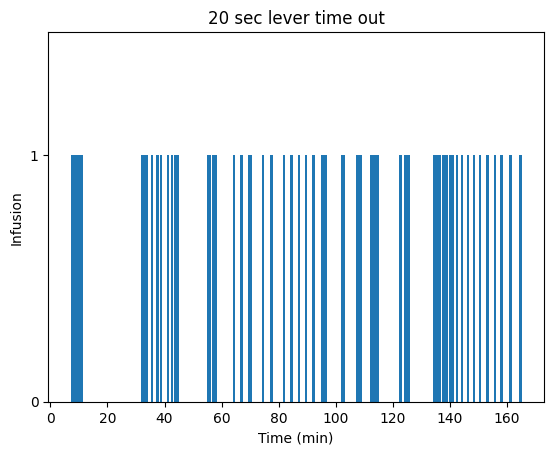

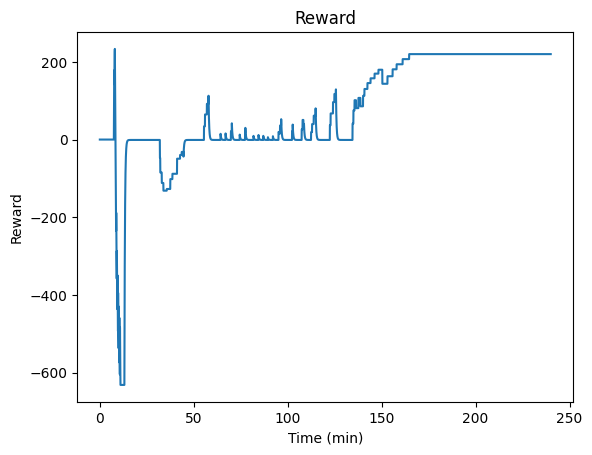

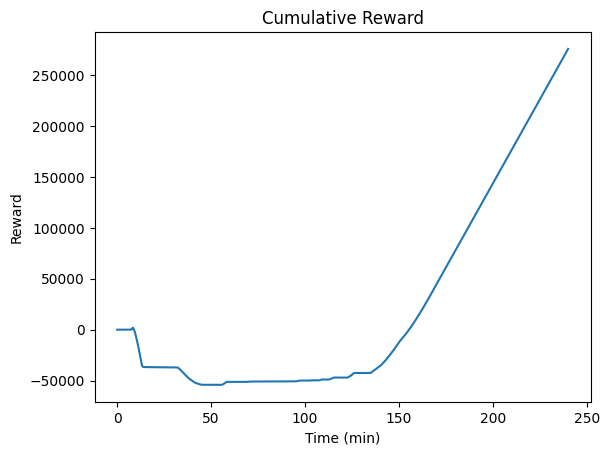

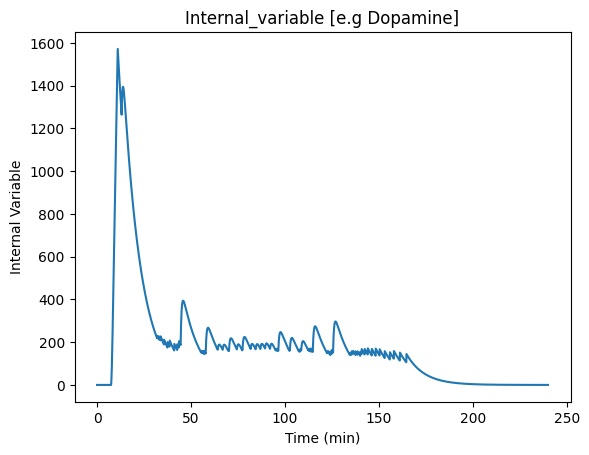

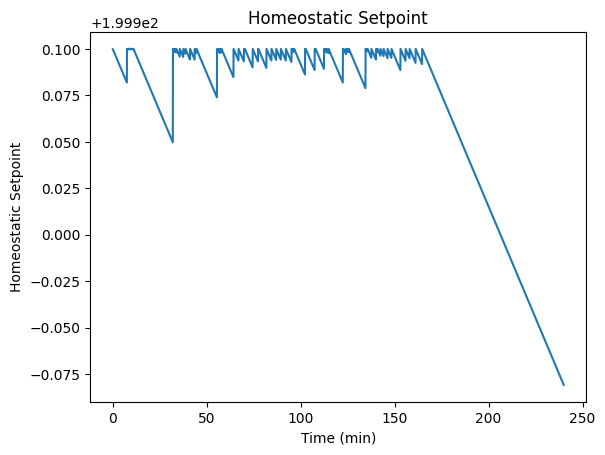

In [8]:
env.close() #close simulation and graph results

#### Generate Dataset
View Synthetic Dataset

In [9]:
#env.df.head(250)
env.df.iloc[100:150] #when hit is taken
#env.df.iloc[0:50]

,epoch,action,epochs_inactive,internal_variable,homeostatic_setpoint,reward,score,time_sec
100,100,Do Nothing,4,0.000000,199.98384,0.000000,0.000000,6.666667
101,101,Do Nothing,0,0.000000,199.98368,0.000000,0.000000,6.733333
102,102,Do Nothing,1,0.000000,199.98352,0.000000,0.000000,6.800000
103,103,Do Nothing,2,0.000000,199.98336,0.000000,0.000000,6.866667
104,104,Do Nothing,3,0.000000,199.98320,0.000000,0.000000,6.933333
105,105,Do Nothing,4,0.000000,199.98304,0.000000,0.000000,7.000000
106,106,Do Nothing,0,0.000000,199.98288,0.000000,0.000000,7.066667
107,107,Do Nothing,1,0.000000,199.98272,0.000000,0.000000,7.133333
108,108,Do Nothing,2,0.000000,199.98256,0.000000,0.000000,7.200000
109,109,Do Nothing,3,0.000000,199.98240,0.000000,0.000000,7.266667


Export Dataset

In [10]:
x = datetime.datetime.now()
file_name = str(x.year) + "_" + str(x.month) + "_" + str(x.day) + "_" + str(x.strftime("%H")) + "_" + str(x.strftime("%M")) + "_" + str(x.strftime("%S")) + ".csv"
env.df.to_csv(file_name, index=False, encoding='utf-8')

#### Save Deep Q Model

In [11]:
agent.save()

#### Create Deep Q-Learning Agent

In [12]:
# Agent Brain - a neural network that represents our Q-function
agent = Dqn(2,env.action_space.n,0.95) # 4 sensors, 2 actions, gama = 0.95

### 2. Cartpole Simulator
Simulate balancing a pole

In [13]:
env = gym.make('CartPole-v1', render_mode='human')
observation = env.reset()[0]

print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

2
Discrete(2)
4
[ 0.0243489  -0.03178375  0.02984336  0.01600212]


In [14]:
# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
agent = Dqn(s,a,g) # deep q learning agent
reward = 0

In [15]:
for _ in range(1000):
    #env.render()
    action, qValues, transitionProbs = agent.update(reward, observation)
    observation, reward, terminated, truncated, info = env.step(action.item())

    if terminated or truncated:
        observation, info = env.reset()
env.close()

### 3. Lunar Lander Simulator
Simulating landing on the moon with a LunarLander

In [16]:
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset(seed=42)
reward = 0

In [17]:
# Agent Brain - a neural network that represents our Q-function
agent = Dqn(8,4,0.9) # 8 sensors, 8 actions, gama = 0.9

In [18]:
for _ in range(1000):
   env.render()
   action, qValues, transitionProbs = agent.update(reward, observation)
   observation, reward, terminated, truncated, info = env.step(int(action))
   if terminated or truncated:
      observation, info = env.reset()
env.close()

## References


## Appendix

### Setup Virtual Environment
1. make sure python3 is installed on your system.
2. make sure you have a python virtual environment setup: 
python -m pip install --upgrade pip setuptools virtualenv
3. create a python environment: 
python -m venv venv (this creates a virtual environment called venv)
4. if applicable add /venv/ to your .gitignore.
5. activate the virtual environment: 
either \venv\Scripts\activate.bat on windows 
or source venv/bin/activate on mac+linux
